# Import libraries

In [ ]:
!pip install pyspark
!pip install apache-beam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=f8ff6baf15fa6350281c12efafaa9313d9f1e3c11db0e2405a0f139df0bbbb39
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 5.7 MB/s eta 0:00:00
  Preparing me

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Recommender System").config("spark.sql.crossJoin.enabled","true").getOrCreate()

In [ ]:
# import library ALS for collaborative filtering
from pyspark.ml.recommendation import ALS
#import library RegressionEvaluator for model evaluation
from pyspark.ml.evaluation import RegressionEvaluator
# import library VectorAssembler for feature vectorization
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as f
import matplotlib.pyplot as plt
import seaborn as sns


# Load and verify data

In [ ]:
#Defining Schema for the DataFrame for movie ranting data
from pyspark.sql.types import StringType, DoubleType, IntegerType, StructType, StructField
schema = StructType([StructField('userId', IntegerType(), True),
                     StructField('movieId', IntegerType(), True),
                     StructField('rating', IntegerType(), True),
                     StructField('timestamp', DoubleType(), True)])


In [ ]:
data = spark.read.csv('ratings.dat',sep = '::', header = False, schema = schema)


In [ ]:
data.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: double (nullable = true)



In [ ]:
# prompt: check for null values

data.select([f.count(f.when(f.isnull(c), c)) for c in data.columns]).show()


+-------------------------------------------------+---------------------------------------------------+-------------------------------------------------+-------------------------------------------------------+
|count(CASE WHEN (userId IS NULL) THEN userId END)|count(CASE WHEN (movieId IS NULL) THEN movieId END)|count(CASE WHEN (rating IS NULL) THEN rating END)|count(CASE WHEN (timestamp IS NULL) THEN timestamp END)|
+-------------------------------------------------+---------------------------------------------------+-------------------------------------------------+-------------------------------------------------------+
|                                                0|                                                  0|                                                0|                                                      0|
+-------------------------------------------------+---------------------------------------------------+-------------------------------------------------+-------

In [ ]:
data.head(3)

[Row(userId=1, movieId=1193, rating=5, timestamp=978300760.0),
 Row(userId=1, movieId=661, rating=3, timestamp=978302109.0),
 Row(userId=1, movieId=914, rating=3, timestamp=978301968.0)]

In [ ]:
#Prints each item in the first row of the DataFrame.
for item in data.head(1)[0]:
    print(item)

1
1193
5
978300760.0


In [ ]:
#Returns the list of column names in the DataFrame.
data.columns

['userId', 'movieId', 'rating', 'timestamp']

In [ ]:
data.describe().show()

+-------+------------------+------------------+------------------+-------------------+
|summary|            userId|           movieId|            rating|          timestamp|
+-------+------------------+------------------+------------------+-------------------+
|  count|             44715|             44715|             44715|              44715|
|   mean|156.81252376160126|1863.3737224644974|3.6044056804204407|9.800126810664207E8|
| stddev| 85.65955369961019| 1106.229221591832|1.1233107277687648|1.058981792624632E7|
|    min|                 1|                 1|                 1|        9.7650374E7|
|    max|               302|              3952|                 5|      1.046325855E9|
+-------+------------------+------------------+------------------+-------------------+



# Train Test split

In [ ]:
#Splitting Data into Training and Testing Sets
#Randomly splits the data into training (70%) and testing (30%) sets
train_data,test_data = data.randomSplit([0.7,0.3])

In [ ]:
train_data.describe().show()

+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|             31187|             31187|             31187|               31187|
|   mean|157.05447782729985|1865.1106550806426|3.6021419181069034|  9.79974738536249E8|
| stddev| 85.77470127769769|1107.4696781512407|1.1213399231442032|1.0881119304586563E7|
|    min|                 1|                 1|                 1|         9.7650374E7|
|    max|               302|              3952|                 5|       1.045358834E9|
+-------+------------------+------------------+------------------+--------------------+



In [ ]:
test_data.describe().show()

+-------+-----------------+------------------+------------------+-------------------+
|summary|           userId|           movieId|            rating|          timestamp|
+-------+-----------------+------------------+------------------+-------------------+
|  count|            13528|             13528|             13528|              13528|
|   mean|156.2547309284447|1859.3694559432288|3.6096244825547013|9.801001525099792E8|
| stddev|85.39405750886117|1103.3946577669913|1.1278652641789502|  9885444.477854187|
|    min|                1|                 1|                 1|       9.76503381E8|
|    max|              302|              3952|                 5|      1.046325855E9|
+-------+-----------------+------------------+------------------+-------------------+



# Build Model

In [ ]:
#Initializes the ALS (Alternating Least Squares) collaborative filtering model with specified parameters.
recommender = ALS(maxIter = 5, regParam = 0.01, userCol='userId', itemCol='movieId', ratingCol='rating')
# recommender = ALS(maxIter = 5, regParam = 0.01, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy="drop")

In [ ]:
train_data = train_data.fillna(0)


In [ ]:
train_data = train_data.dropna(subset=['movieId'])

ALS in regression

In [ ]:
model = recommender.fit(train_data)

In [ ]:
# Make predictions on the test data using the 'transform' method
pred_data = model.transform(test_data)

In [ ]:
from pyspark.sql.functions import col, expr
# Set negative predictions to zero
pred_data = pred_data.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 ELSE prediction END"))


In [ ]:
pred_data.show()

+------+-------+------+-------------+----------+
|userId|movieId|rating|    timestamp|prediction|
+------+-------+------+-------------+----------+
|   148|   2142|     4| 9.79578765E8| 1.9322473|
|   148|   2366|     5| 9.77333254E8| 5.0296926|
|   137|   1580|     4|1.000867526E9|  4.056849|
|   137|   1959|     5| 9.77373314E8| 4.4341836|
|   137|   3175|     5| 9.77373226E8| 4.0564637|
|   251|   1580|     4| 9.76715892E8|  3.363236|
|    65|   1580|     5| 9.77888445E8|  4.824363|
|    65|   3175|     3| 9.91368938E8| 4.9681196|
|    53|   3175|     5| 9.77949217E8|  4.591555|
|   155|   1580|     4| 9.77255028E8| 3.6751127|
|   300|   2866|     5| 9.76506733E8|  4.906073|
|    26|    463|     3| 9.78271588E8| 1.2333279|
|    26|   1088|     3| 9.78271447E8| 1.2148736|
|   271|   1645|     3| 9.99137907E8| 3.4480374|
|   271|   2366|     5| 9.76636511E8| 3.6310306|
|   223|   1580|     4| 9.76902475E8|  3.613393|
|   285|   1580|     3|1.025213283E9| 3.5169933|
|    22|    833|    

In [ ]:
# Assuming you have a regression model and 'pred_data' contains the predictions
# 'rating' is the actual target variable, and 'prediction' is the predicted variable

# Create a RegressionEvaluator object with RMSE as the metric
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# Evaluate the model on the test data and print the RMSE
print("Root-mean-square error = " + str(evaluator.evaluate(pred_data)))


Root-mean-square error = nan


In [ ]:
evaluator = RegressionEvaluator(metricName='mae',labelCol='rating',predictionCol='prediction')
print("Root-mean-square error = " + str(evaluator.evaluate(pred_data)))

Root-mean-square error = nan


In [ ]:
# A NaN result is due to SPARK-14489 and because the model can't predict values for users for which there's no data.
# A temporary workaround is to exclude rows with predicted NaN values or to replace them with a constant, for instance,
# the general mean rating. However, to map to a real business problem, the data scientist, in collaboration with the
# business owner, must define what happens if such an event occurs. For example, you can provide no recommendation for
# a user until that user rates a few items. Alternatively, before user rates five items, you can use a user-based recommender
# system that's based on the user's profile (that's another recommender system to develop).

# Replace predicted NaN values with the average rating and evaluate the model:

In [ ]:
# Calculate the average rating using the 'groupBy' and 'avg' functions
avgRatings = data.select('rating').groupBy().avg().first()[0]
# Print the result
print ('The average rating in the dataset is: {}'.format(avgRatings))

The average rating in the dataset is: 3.6044056804204407


In [ ]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
print ('The root mean squared error for our model is: {}'.format(evaluator.evaluate(pred_data.na.fill(avgRatings))))

The root mean squared error for our model is: 1.2893445342109082


In [ ]:
# prompt: calculate mea in regression

evaluator = RegressionEvaluator(metricName='mae', labelCol='rating', predictionCol='prediction')
print('The mean absolute error for our model is: {}'.format(evaluator.evaluate(pred_data.na.fill(avgRatings))))


The mean absolute error for our model is: 0.998741232914523


In [ ]:
# Now exclude predicted NaN values and evaluate the model:

In [ ]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
print ('The root mean squared error for our model is: {}'.format(evaluator.evaluate(pred_data.na.drop())))

The root mean squared error for our model is: 1.2888992870914804


In [ ]:
# prompt: generate the r2 square

evaluator = RegressionEvaluator(metricName='r2', labelCol='rating', predictionCol='prediction')
print('The r2 score for our model is: {}'.format(evaluator.evaluate(pred_data.na.drop())))


The r2 score for our model is: -0.31366413913847824


In [ ]:
# prompt: calculate mae(mean absolute error) in regression

evaluator = RegressionEvaluator(metricName='mae', labelCol='rating', predictionCol='prediction')
print('The mean absolute error for our model is: {}'.format(evaluator.evaluate(pred_data.na.drop())))


The mean absolute error for our model is: 0.9972914358351186


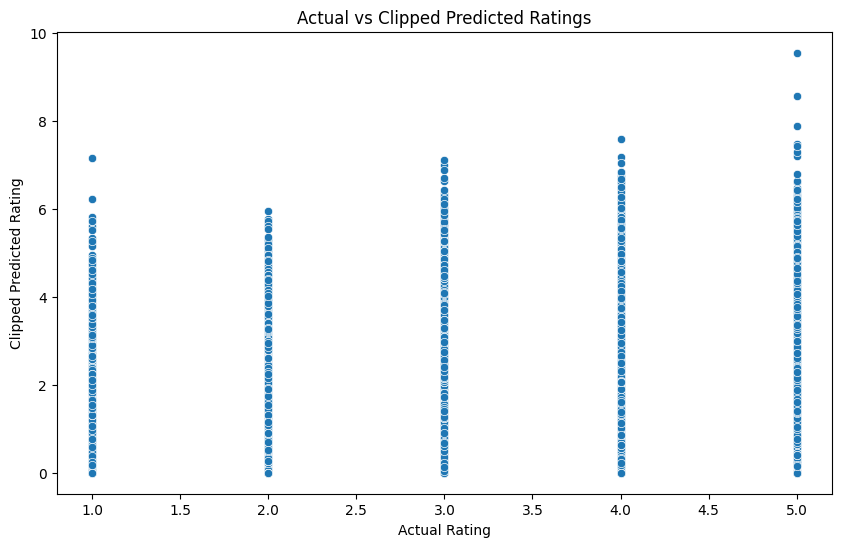

In [ ]:
import numpy as np
predictions_pandas = pred_data.toPandas()
#predictions_pandas['prediction'] = np.clip(predictions_pandas['prediction'], 0, 5)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='prediction', data=predictions_pandas)
plt.title('Actual vs Clipped Predicted Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Clipped Predicted Rating')
plt.show()


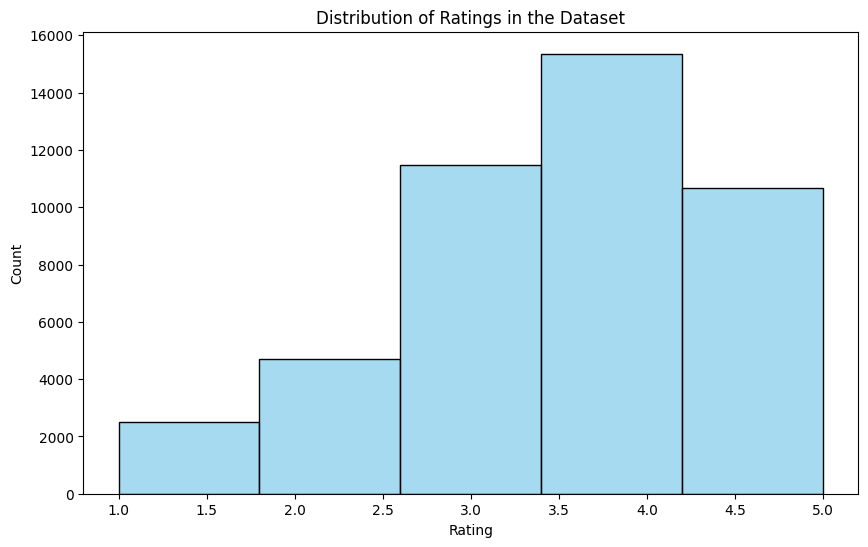

In [ ]:
#Histogram
# Visualize the distribution of ratings in the dataset
ratings_pandas = data.select('rating').toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_pandas['rating'], bins=5, kde=False, color='skyblue')
plt.title('Distribution of Ratings in the Dataset')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
# Non-Collaborative Filtering Model (Random Forest)
vector_assembler_rf = VectorAssembler(inputCols=['userId'], outputCol='features')
rf_regressor = RandomForestRegressor(featuresCol='features', labelCol='rating', numTrees=10)
pipeline_rf = Pipeline(stages=[vector_assembler_rf, rf_regressor])
model_rf = pipeline_rf.fit(data.fillna(0))

In [ ]:
# Evaluate Non-Collaborative Filtering Model (Random Forest)
predictions_rf = model_rf.transform(test_data)
evaluator_rf = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse_rf = evaluator_rf.evaluate(predictions_rf)
print(f"RMSE for Non-Collaborative Filtering Model (Random Forest): {rmse_rf}")


RMSE for Non-Collaborative Filtering Model (Random Forest): 1.114288085875733


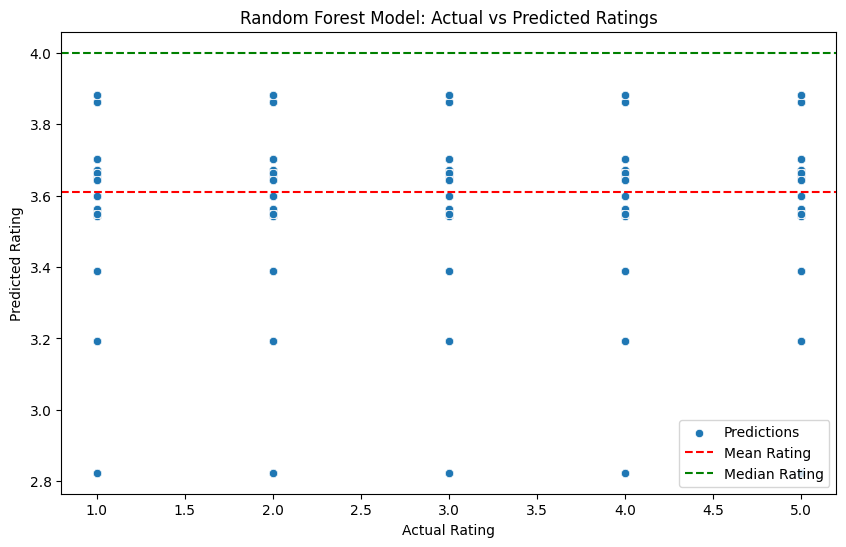

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize predictions for Non-Collaborative Filtering Model (Random Forest)
predictions_rf_pandas = predictions_rf.toPandas()
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(x='rating', y='prediction', data=predictions_rf_pandas, label='Predictions')

# Mean line
mean_rating = predictions_rf_pandas['rating'].mean()
plt.axhline(y=mean_rating, color='r', linestyle='--', label='Mean Rating')

# Median line
median_rating = predictions_rf_pandas['rating'].median()
plt.axhline(y=median_rating, color='g', linestyle='--', label='Median Rating')

# Set title and labels
plt.title('Random Forest Model: Actual vs Predicted Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

# Show legend
plt.legend()

# Show the plot
plt.show()


# Define Movie details




In [ ]:
# Defining Schema for the Movie Details DataFrame
schema = StructType([StructField('movieId', IntegerType(), True),
                     StructField('title', StringType(), True),
                     StructField('genres', StringType(), True)])
movieDetails = spark.read.csv('movies.dat',sep = '::', header = False, schema = schema)
# Printing the Schema of Movie Details DataFrame:
movieDetails.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
movieDetails.head(3)

[Row(movieId=1, title='Toy Story (1995)', genres="Animation|Children's|Comedy"),
 Row(movieId=2, title='Jumanji (1995)', genres="Adventure|Children's|Fantasy"),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance')]

In [ ]:
# Defining Schema for the User Details DataFrame:
schema = StructType([StructField('UserID', IntegerType(), True),
                     StructField('Gender', StringType(), True),
                     StructField('Age', IntegerType(), True),
                     StructField('Occupation', IntegerType(), True),
                     StructField('Zipcode', IntegerType(), True)])
occupation ={
  0:  "other",
  1:  "academic/educator",
  2:  "artist",
  3:  "clerical/admin",
  4:  "college/grad student",
  5:  "customer service",
  6:  "doctor/health care",
  7:  "executive/managerial",
  8:  "farmer",
  9:  "homemaker",
 10:  "K-12 student",
 11:  "lawyer",
 12:  "programmer",
 13:  "retired",
 14:  "sales/marketing",
 15:  "scientist",
 16:  "self-employed",
 17:  "technician/engineer",
 18:  "tradesman/craftsman",
 19:  "unemployed",
 20:  "writer"

}
userDetails = spark.read.csv('users.dat',sep = '::', header = False, schema = schema)
# Printing the Schema of User Details DataFrame:
userDetails.printSchema()

root
 |-- UserID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zipcode: integer (nullable = true)



In [ ]:
userDetails.head(3)

[Row(UserID=1, Gender='F', Age=1, Occupation=10, Zipcode=48067),
 Row(UserID=2, Gender='M', Age=56, Occupation=16, Zipcode=70072),
 Row(UserID=3, Gender='M', Age=25, Occupation=15, Zipcode=55117)]

In [ ]:
# prompt: calculate the null values in both userDetails and movieDetails

userDetails.select([f.count(f.when(f.isnull(c), c)) for c in userDetails.columns]).show()

movieDetails.select([f.count(f.when(f.isnull(c), c)) for c in movieDetails.columns]).show()


+-------------------------------------------------+-------------------------------------------------+-------------------------------------------+---------------------------------------------------------+---------------------------------------------------+
|count(CASE WHEN (UserID IS NULL) THEN UserID END)|count(CASE WHEN (Gender IS NULL) THEN Gender END)|count(CASE WHEN (Age IS NULL) THEN Age END)|count(CASE WHEN (Occupation IS NULL) THEN Occupation END)|count(CASE WHEN (Zipcode IS NULL) THEN Zipcode END)|
+-------------------------------------------------+-------------------------------------------------+-------------------------------------------+---------------------------------------------------------+---------------------------------------------------+
|                                                0|                                                0|                                          0|                                                        0|                             

In [ ]:
# Generate top 10 movie recommendations for each user
# Using the recommendForAllUsers method of the trained ALS model to generate recommendations
userRecs = model.recommendForAllUsers(10)
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{1858, 7.0269175...|
|     2|[{242, 6.6238227}...|
|     3|[{175, 8.507378},...|
|     4|[{2176, 13.126937...|
|     5|[{81, 6.035539}, ...|
|     6|[{955, 7.1403246}...|
|     7|[{724, 9.816499},...|
|     8|[{3554, 7.797468}...|
|     9|[{1554, 6.743209}...|
|    10|[{2861, 7.0046377...|
|    11|[{3019, 6.807482}...|
|    12|[{2609, 8.489271}...|
|    13|[{3554, 5.642074}...|
|    14|[{2403, 12.242307...|
|    15|[{2644, 6.361986}...|
|    16|[{2861, 8.046223}...|
|    17|[{3198, 5.746713}...|
|    18|[{2644, 6.3391347...|
|    19|[{2176, 6.5182347...|
|    20|[{1955, 10.433276...|
+------+--------------------+
only showing top 20 rows



Using Colabrative filtering to combine

In [ ]:
# Using explode to transform the recommendations column into separate rows
userRecsExplode = userRecs.select(userRecs.userId,f.explode(userRecs.recommendations)).orderBy(userRecs.userId)
userRecsExplode.show()

+------+-----------------+
|userId|              col|
+------+-----------------+
|     1|{1858, 7.0269175}|
|     1|  {953, 6.933067}|
|     1|{2019, 6.7472277}|
|     1| {3469, 6.415483}|
|     1|{2861, 6.4066143}|
|     1|{3470, 6.3035064}|
|     1|  {852, 6.262131}|
|     1| {959, 6.2613506}|
|     1| {2287, 6.151389}|
|     1| {2108, 6.128372}|
|     2| {242, 6.6238227}|
|     2|{3182, 6.4797354}|
|     2| {1699, 6.420671}|
|     2|{3836, 6.3850145}|
|     2|{1287, 6.3606815}|
|     2| {1226, 6.233671}|
|     2|{2116, 6.2120585}|
|     2|{2176, 6.1940136}|
|     2| {1231, 6.130916}|
|     2| {1277, 6.115124}|
+------+-----------------+
only showing top 20 rows



In [ ]:
# Generate top 10 movie recommendations for a specified set of users
singleUser = test_data.filter(test_data.userId==250).select(['movieId','userId'])
singleUser.join(movieDetails,singleUser.movieId==movieDetails.movieId,"left").select([singleUser.userId,singleUser.movieId,movieDetails.title,movieDetails.genres]).show()

+------+-------+--------------------+--------------------+
|userId|movieId|               title|              genres|
+------+-------+--------------------+--------------------+
|   250|    464|  Hard Target (1993)|Action|Adventure|...|
|   250|    480|Jurassic Park (1993)|Action|Adventure|...|
|   250|   2858|American Beauty (...|        Comedy|Drama|
|   250|   3078|Liberty Heights (...|               Drama|
|   250|   3452|Romeo Must Die (2...|      Action|Romance|
+------+-------+--------------------+--------------------+



In [ ]:
userSubsetRecs = model.recommendForUserSubset(singleUser, 10)
userSubsetRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   250|[{3019, 10.496857...|
+------+--------------------+



In [ ]:
userSubsetRecsExplode = userSubsetRecs.select(userSubsetRecs.userId,f.explode(userSubsetRecs.recommendations))
userSubsetRecsExplode.show()

+------+-----------------+
|userId|              col|
+------+-----------------+
|   250|{3019, 10.496857}|
|   250|  {3275, 9.41677}|
|   250| {3783, 9.150944}|
|   250|  {3424, 8.89164}|
|   250|   {529, 8.70423}|
|   250| {800, 8.5307865}|
|   250| {1982, 8.525492}|
|   250|{1756, 7.9304037}|
|   250| {2018, 7.929111}|
|   250|{1654, 7.8321934}|
+------+-----------------+



In [ ]:
recommendations = model.transform(singleUser)
userRecommendations= recommendations.orderBy('prediction',ascending=False)
userRecommendations.show()

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|   3078|   250|  6.697952|
|   2858|   250| 5.2664495|
|    480|   250|  3.789679|
|    464|   250| 2.1467695|
|   3452|   250| 1.8067666|
+-------+------+----------+



In [ ]:
userRecommendations.join(movieDetails,userRecommendations.movieId==movieDetails.movieId,"left").select([userRecommendations.userId,movieDetails.title,movieDetails.genres,userRecommendations.prediction]).show()

+------+--------------------+--------------------+----------+
|userId|               title|              genres|prediction|
+------+--------------------+--------------------+----------+
|   250|Romeo Must Die (2...|      Action|Romance| 1.8067666|
|   250|American Beauty (...|        Comedy|Drama| 5.2664495|
|   250|Jurassic Park (1993)|Action|Adventure|...|  3.789679|
|   250|  Hard Target (1993)|Action|Adventure|...| 2.1467695|
|   250|Liberty Heights (...|               Drama|  6.697952|
+------+--------------------+--------------------+----------+



In [ ]:
# Generate top 10 user recommendations for a specified set of movies
singleMovie = test_data.filter(test_data.movieId==34).select(['movieId','userId'])
singleMovie.join(movieDetails,singleMovie.movieId==movieDetails.movieId,"left").select([singleMovie.movieId,movieDetails.title,movieDetails.genres,singleMovie.userId]).show()

+-------+-----------+--------------------+------+
|movieId|      title|              genres|userId|
+-------+-----------+--------------------+------+
|     34|Babe (1995)|Children's|Comedy...|    36|
|     34|Babe (1995)|Children's|Comedy...|    44|
|     34|Babe (1995)|Children's|Comedy...|    45|
|     34|Babe (1995)|Children's|Comedy...|    51|
|     34|Babe (1995)|Children's|Comedy...|    73|
|     34|Babe (1995)|Children's|Comedy...|    75|
|     34|Babe (1995)|Children's|Comedy...|    90|
|     34|Babe (1995)|Children's|Comedy...|    92|
|     34|Babe (1995)|Children's|Comedy...|   137|
|     34|Babe (1995)|Children's|Comedy...|   148|
|     34|Babe (1995)|Children's|Comedy...|   161|
|     34|Babe (1995)|Children's|Comedy...|   175|
|     34|Babe (1995)|Children's|Comedy...|   192|
|     34|Babe (1995)|Children's|Comedy...|   193|
|     34|Babe (1995)|Children's|Comedy...|   194|
|     34|Babe (1995)|Children's|Comedy...|   204|
|     34|Babe (1995)|Children's|Comedy...|   220|


In [ ]:
movieSubSetRecs = model.recommendForItemSubset(singleMovie, 10)
movieSubSetRecs.join(movieDetails,movieSubSetRecs.movieId==movieDetails.movieId,"left").select([movieSubSetRecs.movieId,movieDetails.title,movieDetails.genres,movieSubSetRecs.recommendations]).show()

+-------+-----------+--------------------+--------------------+
|movieId|      title|              genres|     recommendations|
+-------+-----------+--------------------+--------------------+
|     34|Babe (1995)|Children's|Comedy...|[{144, 6.0316334}...|
+-------+-----------+--------------------+--------------------+



In [ ]:
movieSubSetRecsExplode = movieSubSetRecs.select(movieSubSetRecs.movieId,f.explode(movieSubSetRecs.recommendations))
movieSubSetRecsExplode.join(movieDetails,movieSubSetRecsExplode.movieId==movieDetails.movieId,"left").select([movieSubSetRecsExplode.movieId,movieDetails.title,movieDetails.genres,movieSubSetRecsExplode.col.alias('recommendation')]).show()

+-------+-----------+--------------------+----------------+
|movieId|      title|              genres|  recommendation|
+-------+-----------+--------------------+----------------+
|     34|Babe (1995)|Children's|Comedy...|{144, 6.0316334}|
|     34|Babe (1995)|Children's|Comedy...| {292, 6.006903}|
|     34|Babe (1995)|Children's|Comedy...|{128, 5.8326764}|
|     34|Babe (1995)|Children's|Comedy...|{283, 5.6705747}|
|     34|Babe (1995)|Children's|Comedy...| {120, 5.628803}|
|     34|Babe (1995)|Children's|Comedy...| {16, 5.5959005}|
|     34|Babe (1995)|Children's|Comedy...| {80, 5.5196805}|
|     34|Babe (1995)|Children's|Comedy...| {184, 5.479142}|
|     34|Babe (1995)|Children's|Comedy...| {266, 5.475329}|
|     34|Babe (1995)|Children's|Comedy...|{135, 5.4684024}|
+-------+-----------+--------------------+----------------+



In [ ]:
# prompt: append recommendation column into dataset

recommendations_movie = model.transform(test_data)
recommendations_movie.join(movieDetails,recommendations_movie.movieId==movieDetails.movieId,"left").select([recommendations_movie.userId,movieDetails.title,movieDetails.genres,recommendations_movie.prediction]).show()


+------+--------------------+--------------------+----------+
|userId|               title|              genres|prediction|
+------+--------------------+--------------------+----------+
|     1|   Awakenings (1990)|               Drama| 4.7005258|
|     1|          Big (1988)|      Comedy|Fantasy| 3.8124132|
|     1|        Bambi (1942)|Animation|Children's|  3.584227|
|     1| My Fair Lady (1964)|     Musical|Romance| 5.7263775|
|     1|Christmas Story, ...|        Comedy|Drama|  4.003933|
|     1|    Toy Story (1995)|Animation|Childre...| 4.8231034|
|     1|Wizard of Oz, The...|Adventure|Childre...|  4.830664|
|     1| Mary Poppins (1964)|Children's|Comedy...| 4.7933455|
|     1|Sound of Music, T...|             Musical|  4.769859|
|     2|Die Hard: With a ...|     Action|Thriller|   5.11145|
|     1|Erin Brockovich (...|               Drama|  4.044266|
|     1|      Ben-Hur (1959)|Action|Adventure|...| 4.7532244|
|     1|         Gigi (1958)|             Musical| 3.2854478|
|     2|

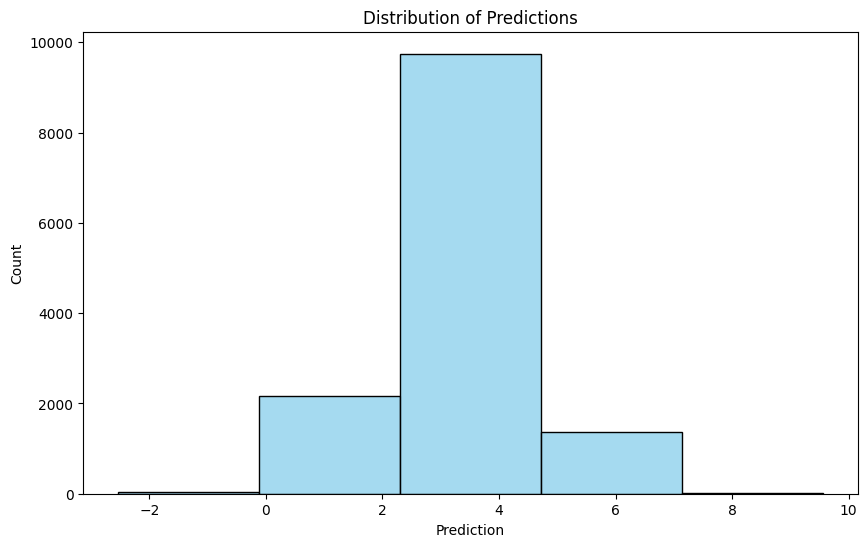

In [ ]:
# prompt: plot histogram for userId and Prediction

predictions = recommendations_movie.select('prediction')
predictions_pandas = predictions.toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(predictions_pandas['prediction'], bins=5, kde=False, color='skyblue')
plt.title('Distribution of Predictions')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()


In [ ]:
# prompt:  calculate mean absolute error for prediction in recommendations

evaluator = RegressionEvaluator(metricName='mae', labelCol='rating', predictionCol='prediction')
print('The mean absolute error for our model is: {}'.format(evaluator.evaluate(pred_data.na.drop())))


The mean absolute error for our model is: 0.9972914358351186


In [ ]:
# prompt: calculate mean absolute error for prediction in recommendations for each user

user_mae = recommendations.toPandas().groupby('userId').agg({'prediction': 'mean'}).reset_index()
user_mae.rename(columns={'mean(prediction)': 'mae'}, inplace=True)
user_mae.head()

,userId,prediction
0,250,3.941523


In [ ]:
1# prompt: calculate mse for predictions in recommendations

evaluator = RegressionEvaluator(metricName='rmse', labelCol='userId', predictionCol='prediction')
print('The root mean squared error for our model is: ', evaluator.evaluate(recommendations.dropna()))


The root mean squared error for our model is:  246.0654484141157


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming 'recommendations' is your DataFrame with predictions
evaluator = RegressionEvaluator(metricName='rmse', labelCol='userId', predictionCol='prediction')
mse = evaluator.evaluate(recommendations.dropna())

# Assuming you have a reference value 'reference_mse' to compare against
reference_mse = 0.25  # Replace this with your reference MSE value

# Calculate the percentage of MSE relative to the reference value
mse_percentage = (mse / reference_mse) * 100

print('The MSE for our model is: {:.2f}% of the reference MSE.'.format(mse_percentage))


The MSE for our model is: 98426.18% of the reference MSE.


In [ ]:
1# prompt: calculate mse for predictions in recommendations

evaluator = RegressionEvaluator(metricName='mae', labelCol='userId', predictionCol='prediction')
print('The root mean squared error for our model is: ', evaluator.evaluate(recommendations.dropna()))


The root mean squared error for our model is:  246.05847671031952
